In [108]:
library(randomForest)
library(partykit)
library(rpart)
library(mobForest)
library(e1071)
library(nnet)
library(caret)
library(corrplot)
library(grDevices)
library(RColorBrewer)
library(plotmo)

Loading required package: Formula

Loading required package: plotrix

Loading required package: TeachingDemos



# Méthodes de machine learning

In [2]:
data_tot = read.csv('./Donnees/Plusieurs_pays/Total.csv', header = TRUE)
data_tot = data_tot[-c(47,60)]

Création d'un nouveau dataframe sans les variables `Rating` et `Pays`, utilisé après :

In [3]:
#data = data_tot[,-c(81,82,83,84)]
data = data_tot[,-c(34:46,55:60,72:84)]
data_but_tot = data * data_tot$Nombre

In [22]:
data_but_tot_pts = cbind(data_but_tot, data_tot$Points)

In [25]:
names(data_but_tot_pts)[53] <- "Points"

## Random Forest sur la variable Points

### Extraction d'un arbre de la forêt 

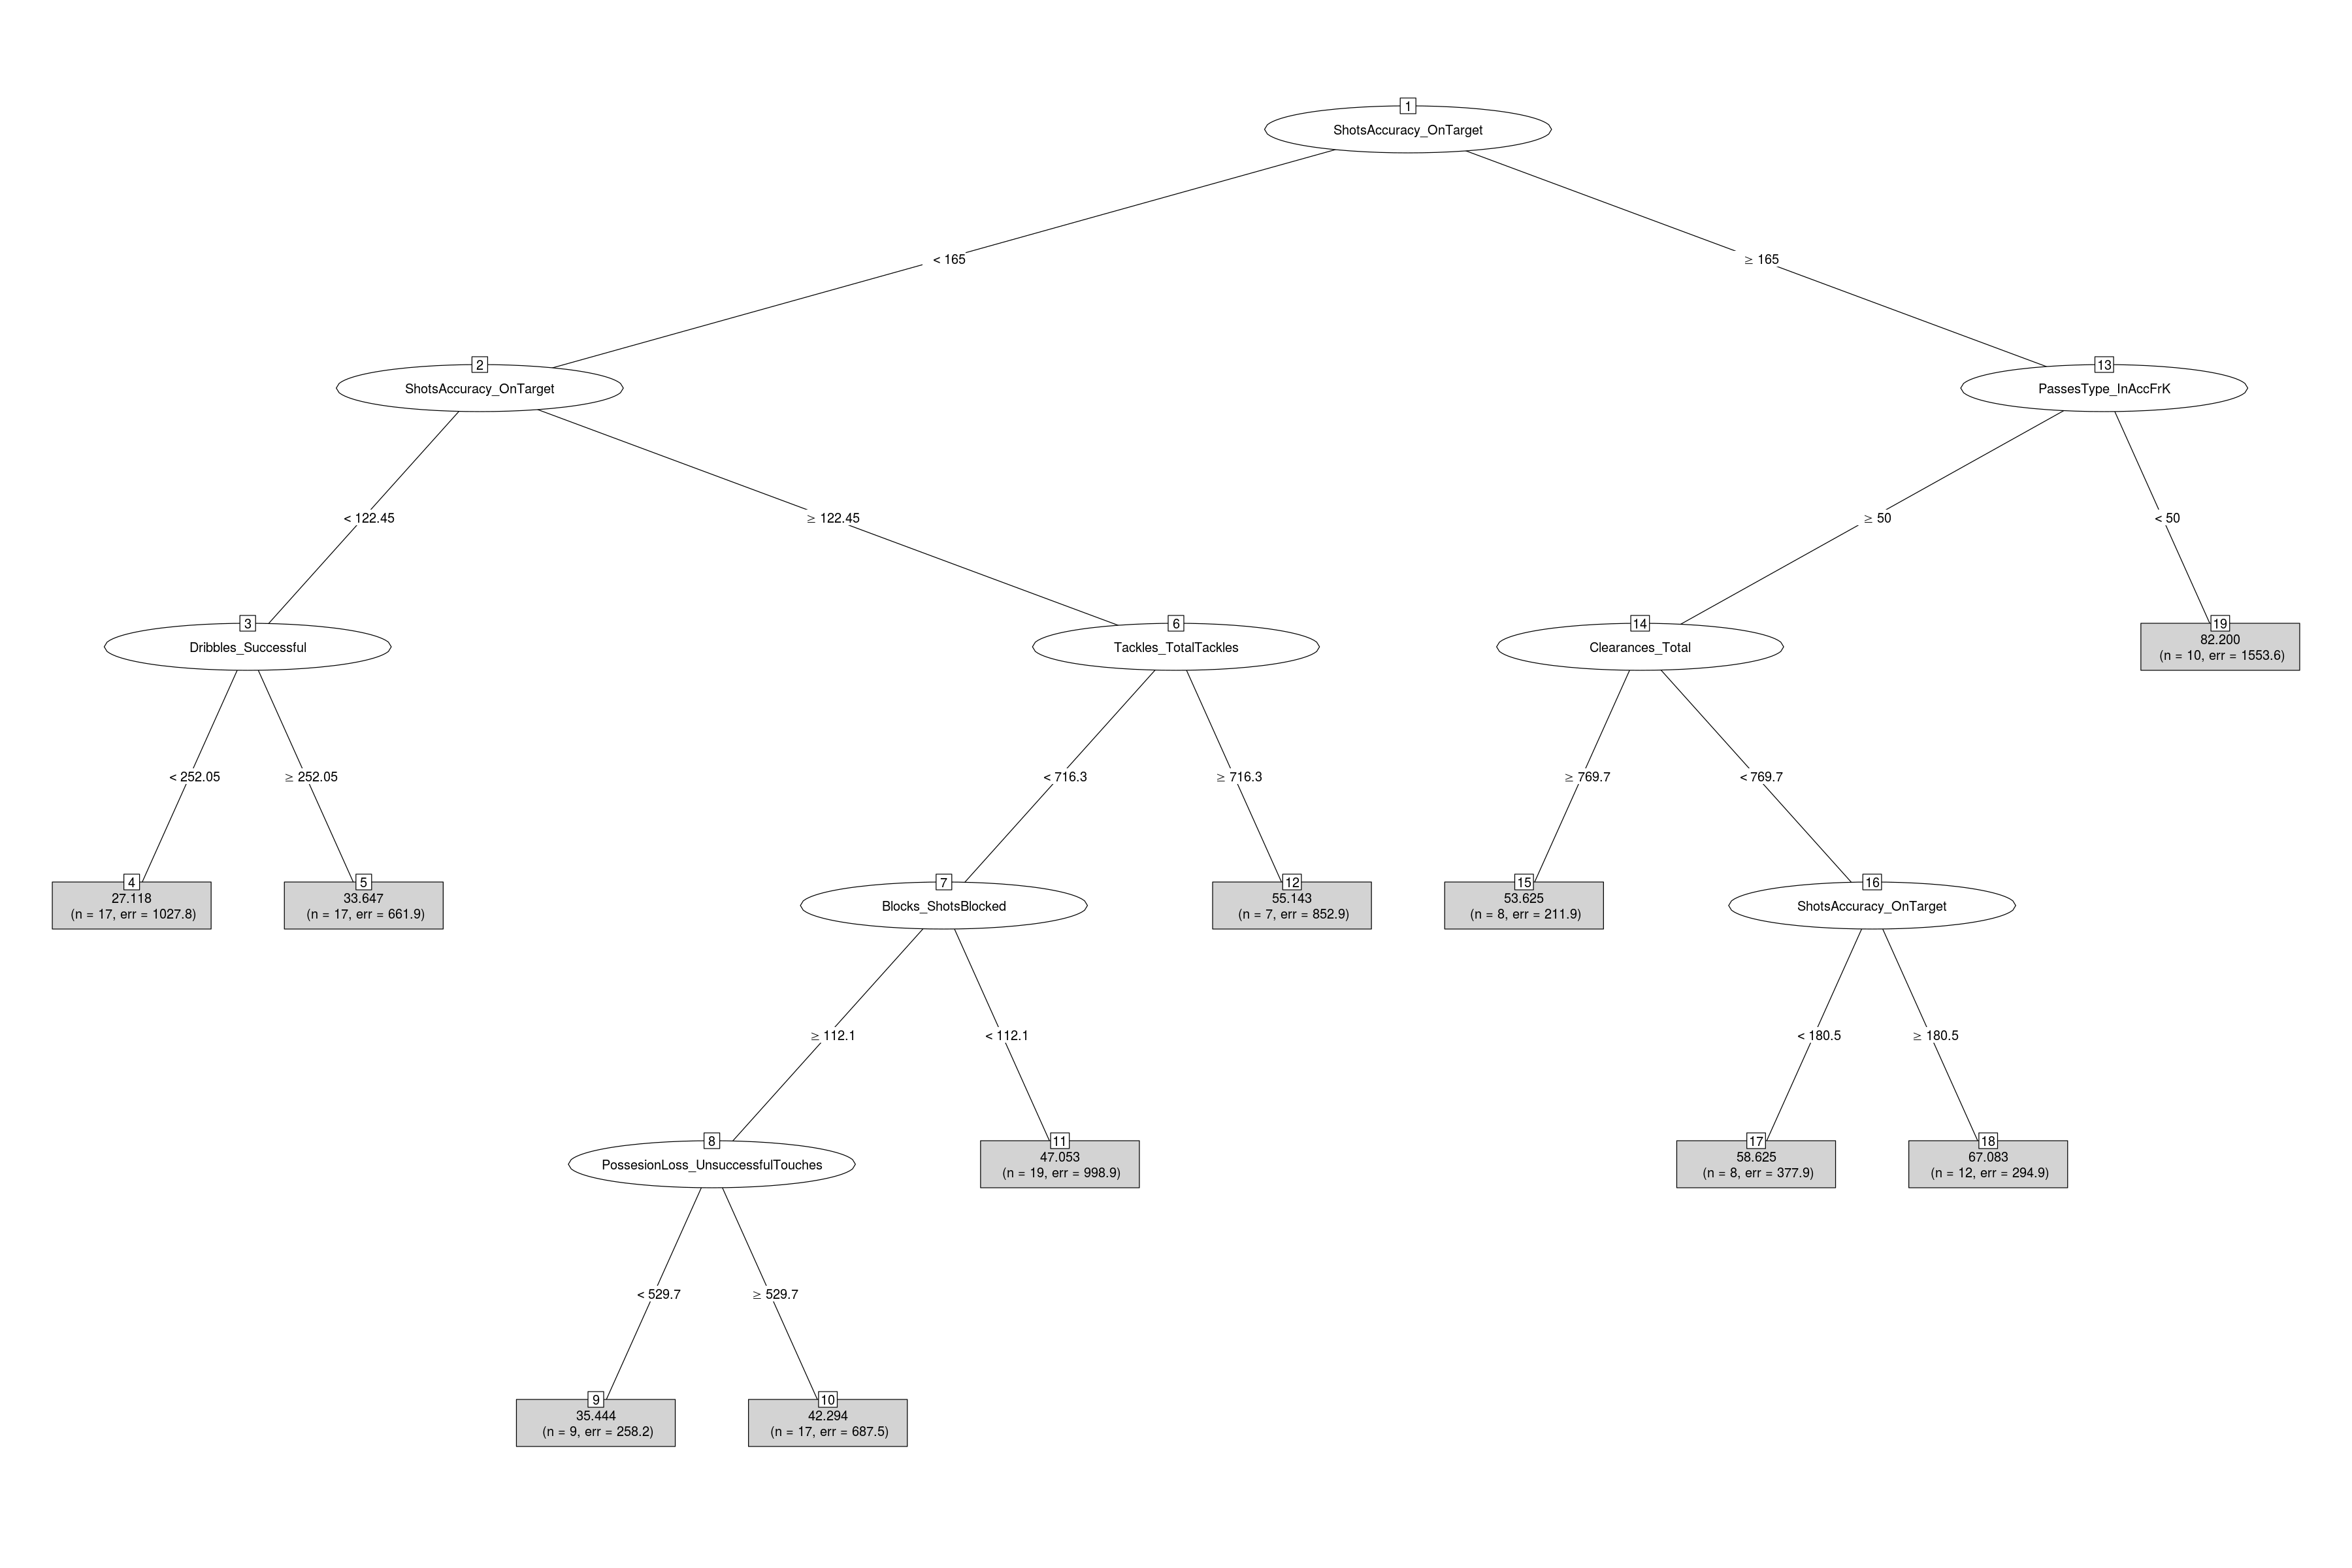

In [5]:
tree.points = rpart(data_tot$Points ~ ., data=data_but_tot, control=rpart.control(cp=0.0001))
        # le parametre cp permet de contrôler l'élagage de l'arbre

options(repr.plot.width=30, repr.plot.height=20)
plot(as.party(tree.points), type="simple")

Ici, la variable permettant de faire une première séparation, et qui est donc la plus importante est `ShotsAccuracy_OnTarget`. Elle réapparait encore après, sur chacun des deux sous arbres principaux. Cette variable est donc très importante pour la régression.

### Application du random Forest

In [6]:
#points.rf = randomForest(as.factor(data_tot$Points) ~ ., data=data_but_tot)
points.rf = randomForest(data_tot$Points ~ ., data=data_but_tot)

In [7]:
print(points.rf)


Call:
 randomForest(formula = data_tot$Points ~ ., data = data_but_tot) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 17

          Mean of squared residuals: 93.92864
                    % Var explained: 68.83


Ici on compte 10 variables importantes d'après RandomForest pour expliquer `Points`.

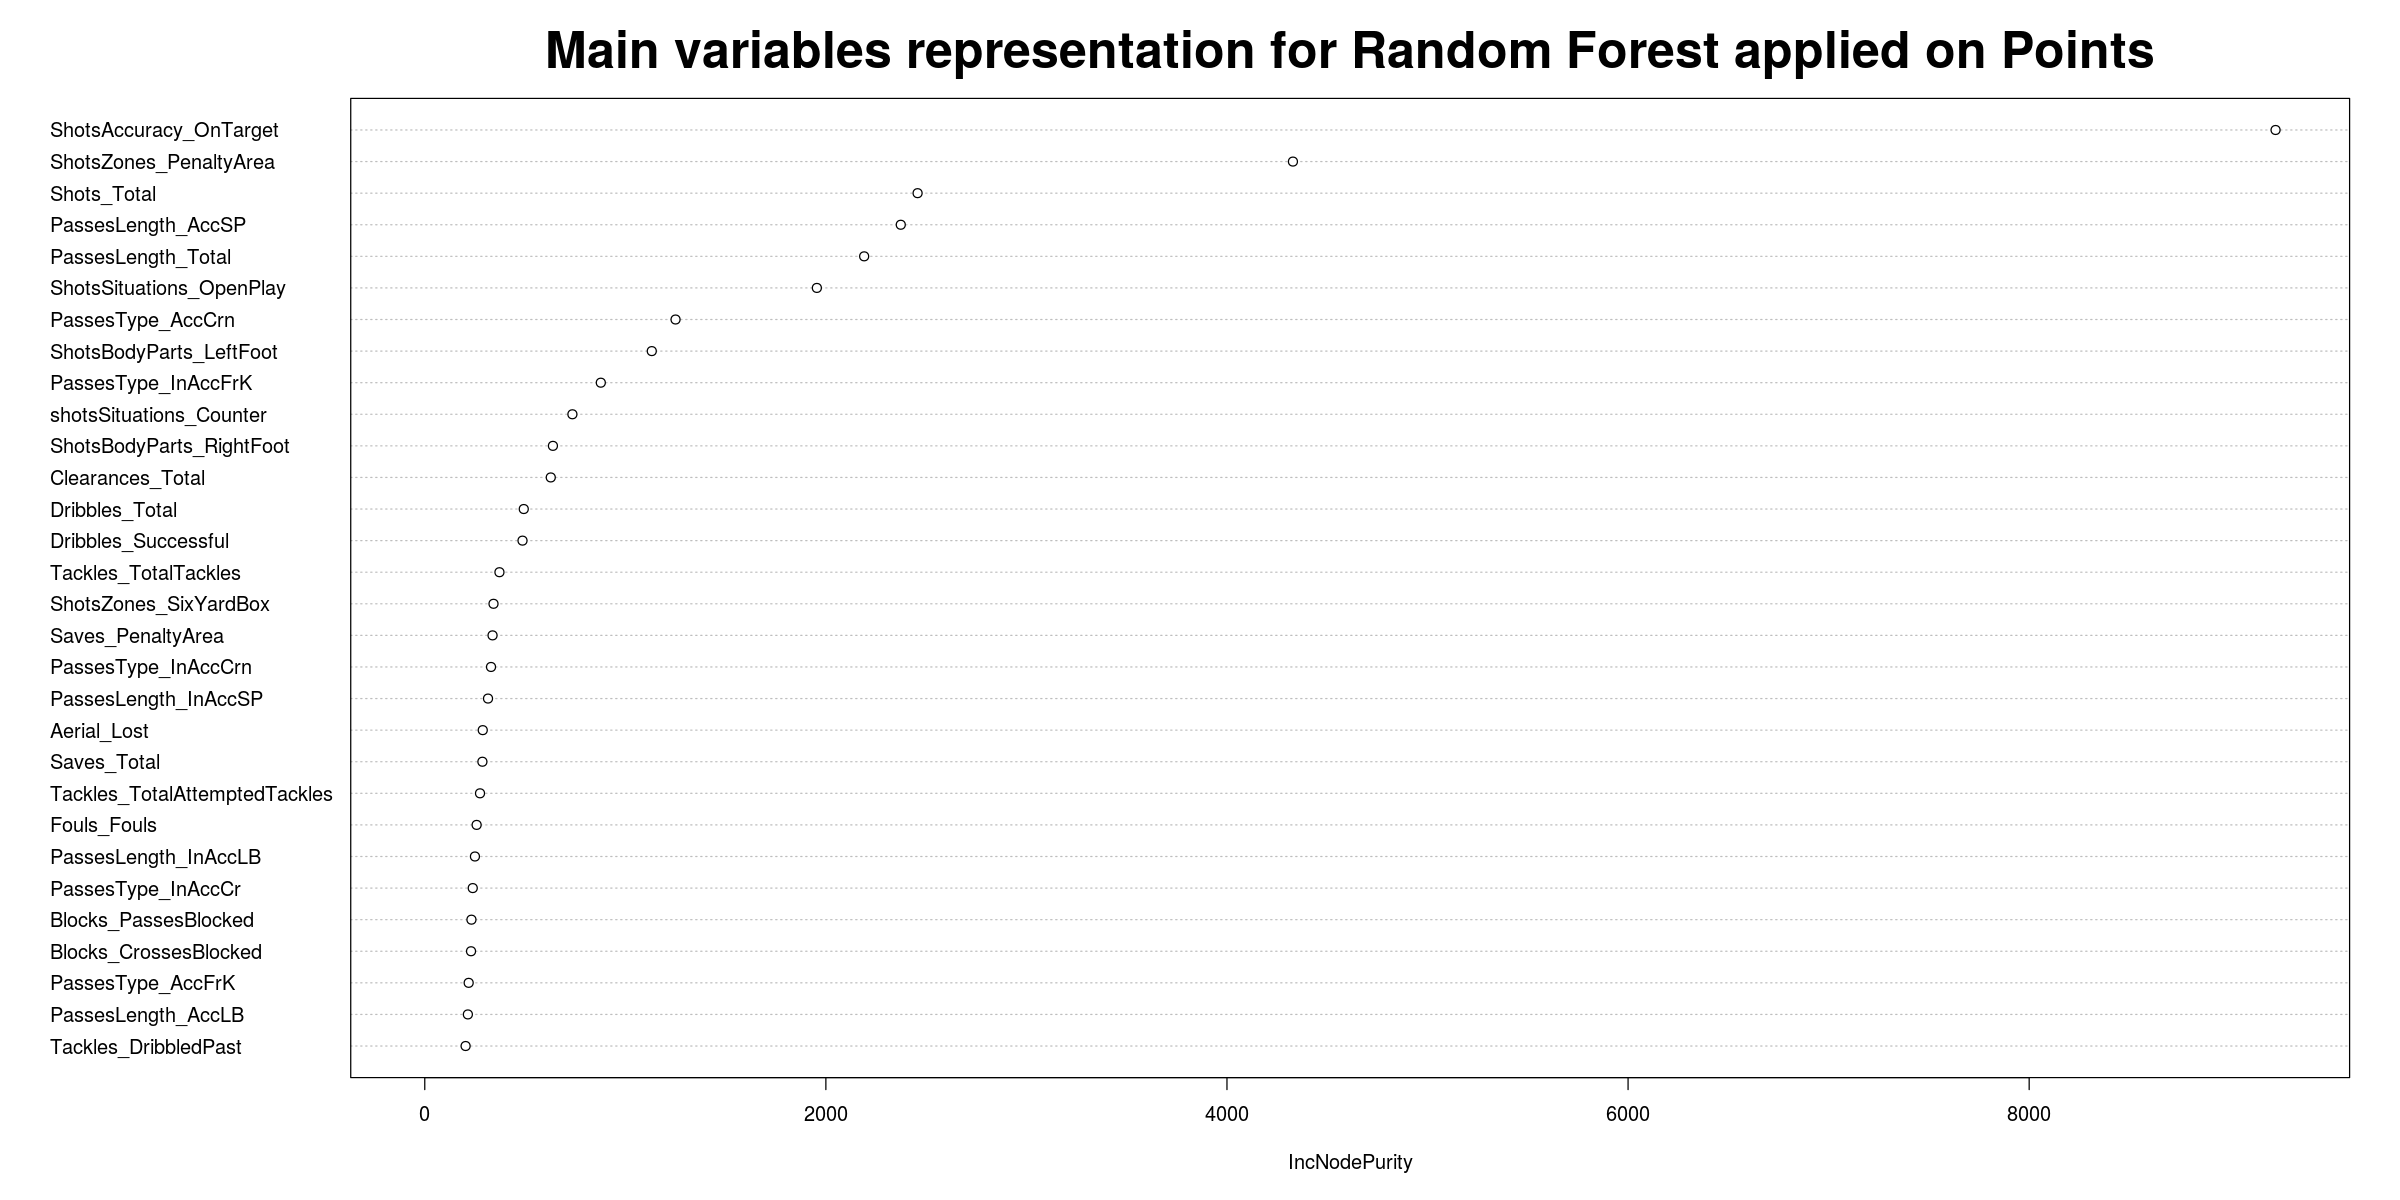

In [8]:
options(repr.plot.width=20, repr.plot.height=10)
varImpPlot(points.rf, main = "Main variables representation for Random Forest applied on Points", cex.main = 2.5)

Les principales variables mises en exergue par random forest sont `ShotsAccuracy_OnTarget`, `ShotsZones_PenaltyArea`, `Shots_Total`, `PassesLength_Total`, `PassesLength_AccSP`, `ShotsBodyParts_LeftFoot`, `ShotsSituations_OpenPlay`, `PasseType_InAccFrk` et `PassesType_AccCrn`

#### Prédiction sur le nombre de points

Il faut faire du nettoyage : en faisant de la régression ça marche, on a un $R2$ plutôt pas mal mais il fait de la régression donc on obtient des valeurs prédites non entières. Est-ce que si on récupère la partie entière des predict c'est trop faux ??

A l'inverse, quand on essaie de faire de la classification, où chaque classe = 1 entier, on prédit exactement les bonnes valeurs donc sans doute qu'on a fait du suraprentissage.

In [9]:
predict.points.rf = predict(points.rf, data_but_tot)
#predict.points.integer = as.numeric(as.character(predict.points))
#residus.points = data_tot$Points - predict.points.integer
residus.points.rf = data_tot$Points - predict.points.rf

In [10]:
sort(round(predict.points.rf), decreasing = TRUE)

Manchester City     Paris Saint-Germain               Liverpool 
                     90                      86                      86 
              Barcelona                Juventus           Bayern Munich 
                     85                      81                      81 
                 Napoli                 Chelsea                    Lyon 
                     78                      76                      75 
            Real Madrid  RasenBallsport Leipzig                Atalanta 
                     71                      69                      68 
                   Roma               Tottenham                   Lille 
                     68                      68                      67 
               AC Milan                   Inter                  Torino 
                     66                      66                      65 
      Borussia Dortmund                 Arsenal         Atletico Madrid 
                     65                      65                      62 
       Bayer Leverkusen              Hoffenheim             Montpellier 
                     61                      61                      60 
              Marseille                   Lazio                 Sevilla 
                     60                      60                      60 
         Crystal Palace           Saint-Etienne              Villarreal 
                     59                      58                      58 
              Leicester                Valencia       Manchester United 
                     57                      56                      55 
                  Nimes               Sampdoria                   Eibar 
                     54                      54                      54 
                Everton                    Nice              Fiorentina 
                     54                      52                      52 
    Borussia M.Gladbach           Werder Bremen              Real Betis 
                     52                      52                      52 
    Eintracht Frankfurt               Wolfsburg              Celta Vigo 
                     51                      51                      51 
               West Ham Wolverhampton Wanderers                  Rennes 
                     51                      51                      50 
                 Nantes              Strasbourg           Real Sociedad 
                     50                      49                      49 
               Espanyol            Boca Juniors             Racing Club 
                     49                      49                      48 
                  Reims                Sassuolo                  Getafe 
                     47                      47                      47 
            River Plate                  Angers        Newcastle United 
                     47                      46                      46 
               Mainz 05         Athletic Bilbao                 Bologna 
                     45                      45                      44 
                  Genoa           Hertha Berlin     Fortuna Duesseldorf 
                     44                      44                      44 
                Leganes                 Watford                Bordeaux 
                     44                      44                      43 
                 Monaco                 Levante             Southampton 
                     43                      43                      43 
            Bournemouth                 Udinese               SPAL 2013 
                     43                      42                      42 
                 Empoli        Deportivo Alaves      Defensa y Justicia 
                     42                      42                      41 
               Toulouse                  Girona               SD Huesca 
                     40                      40                      40 
                Burnley                   Dijon                Cag

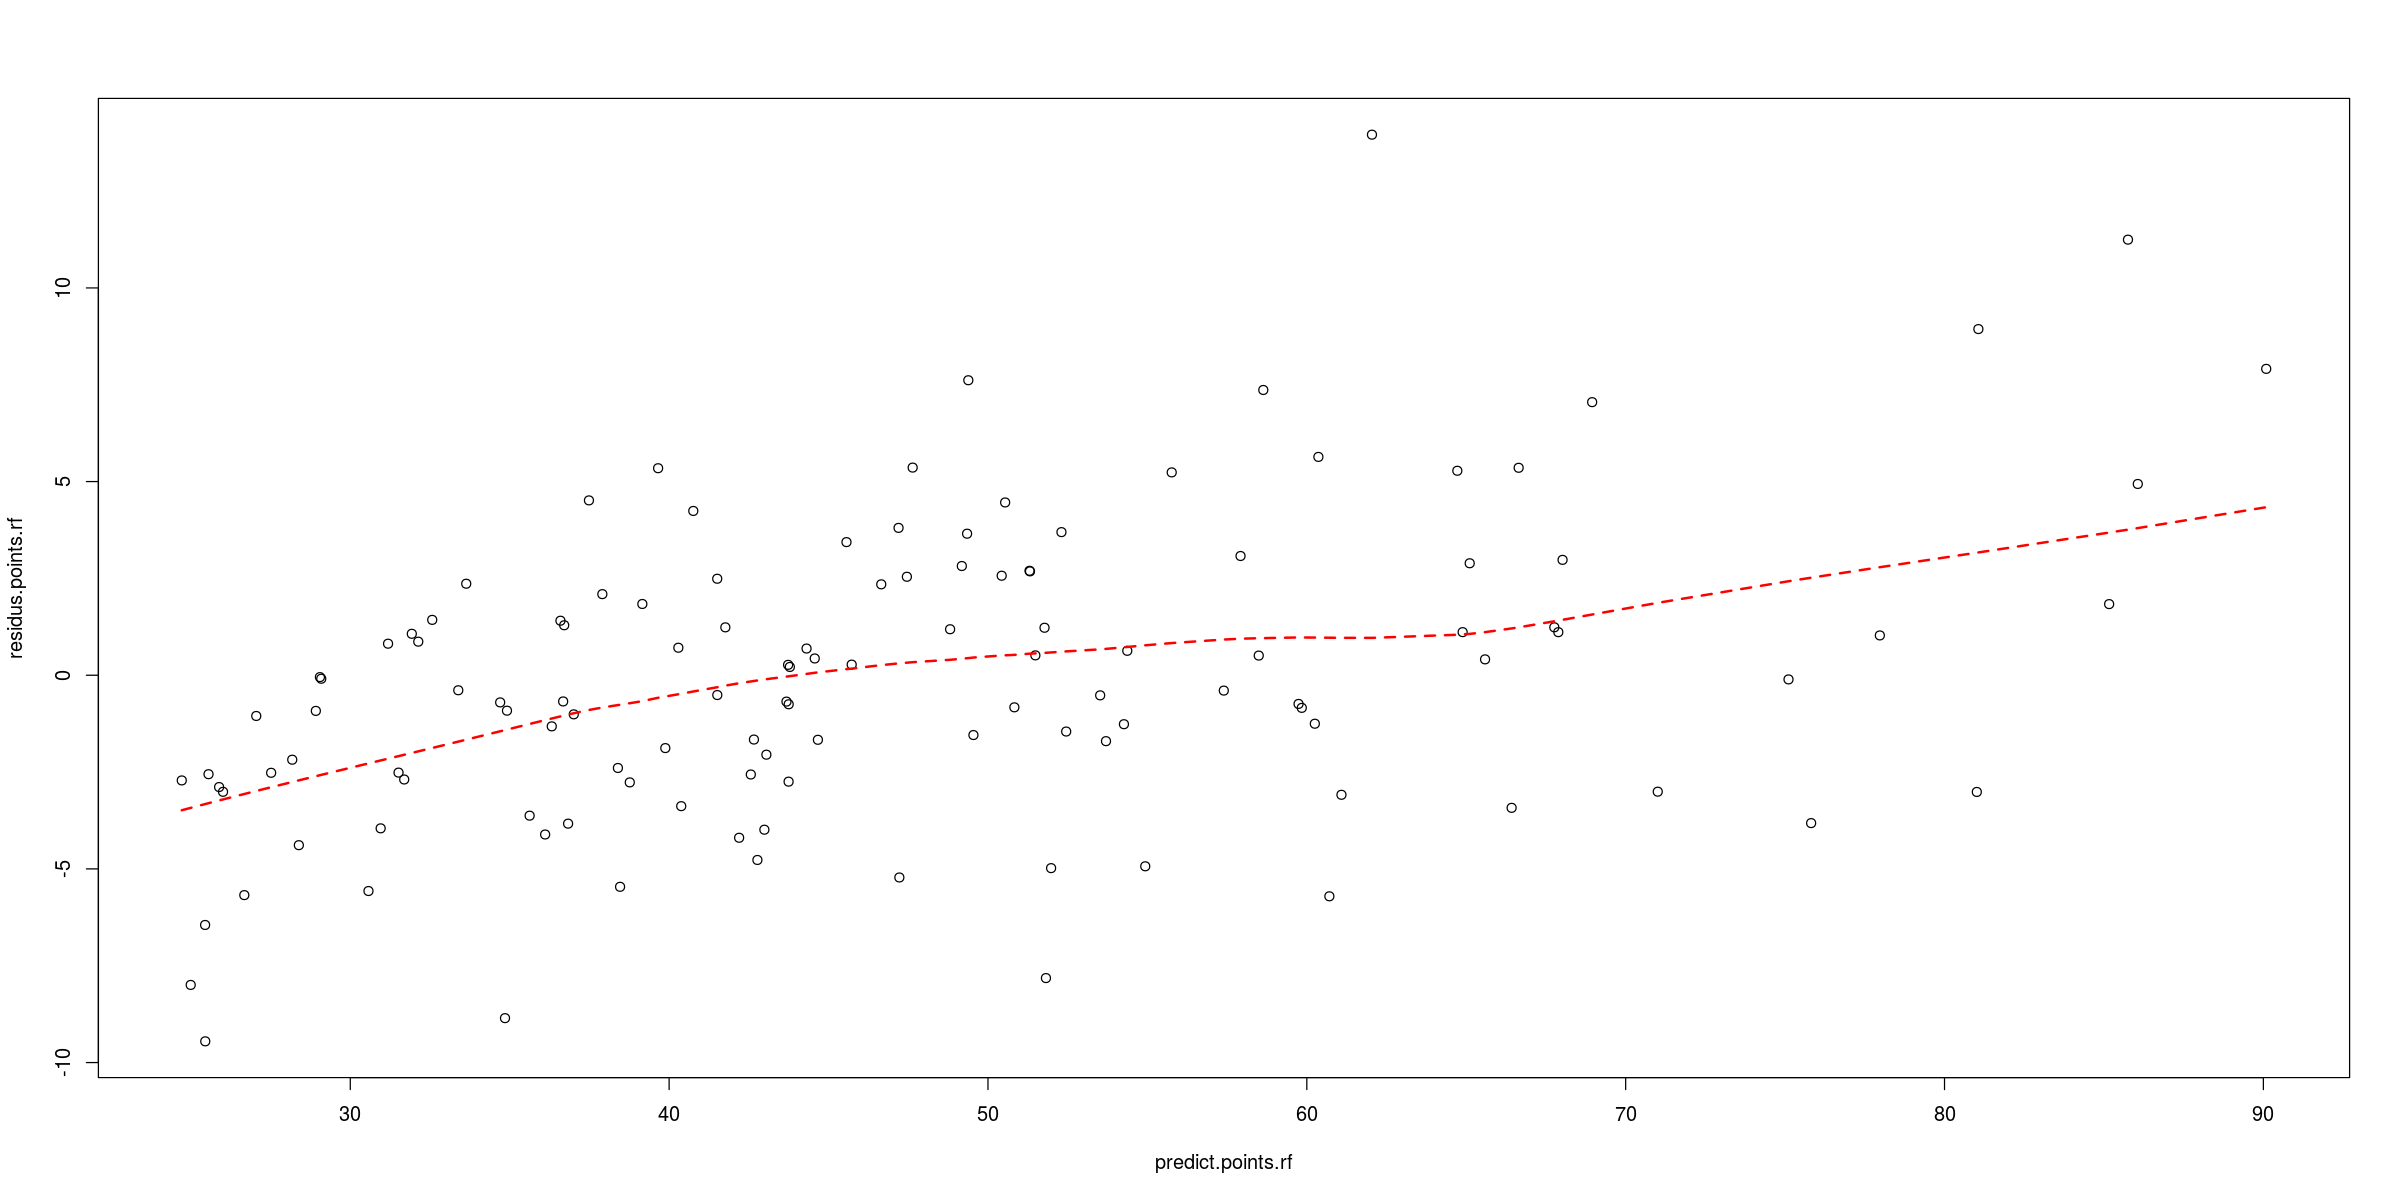

In [11]:
plot(predict.points.rf, residus.points.rf)
lines(lowess(predict.points.rf, residus.points.rf), col = 2, lty = 2, lwd = 2)

In [12]:
r.squared.points = 1-sum(residus.points.rf**2)/(length(data_tot$Points)*var(data_tot$Points))
r.squared.points

[1] 0.9495368

In [13]:
sum(residus.points.rf**2)/124*300

[1] 4598.727

### En utilisant caret

In [43]:
rf.points.caret = train(Points ~ ., data=data_but_tot_pts, method="rf", importance = TRUE)

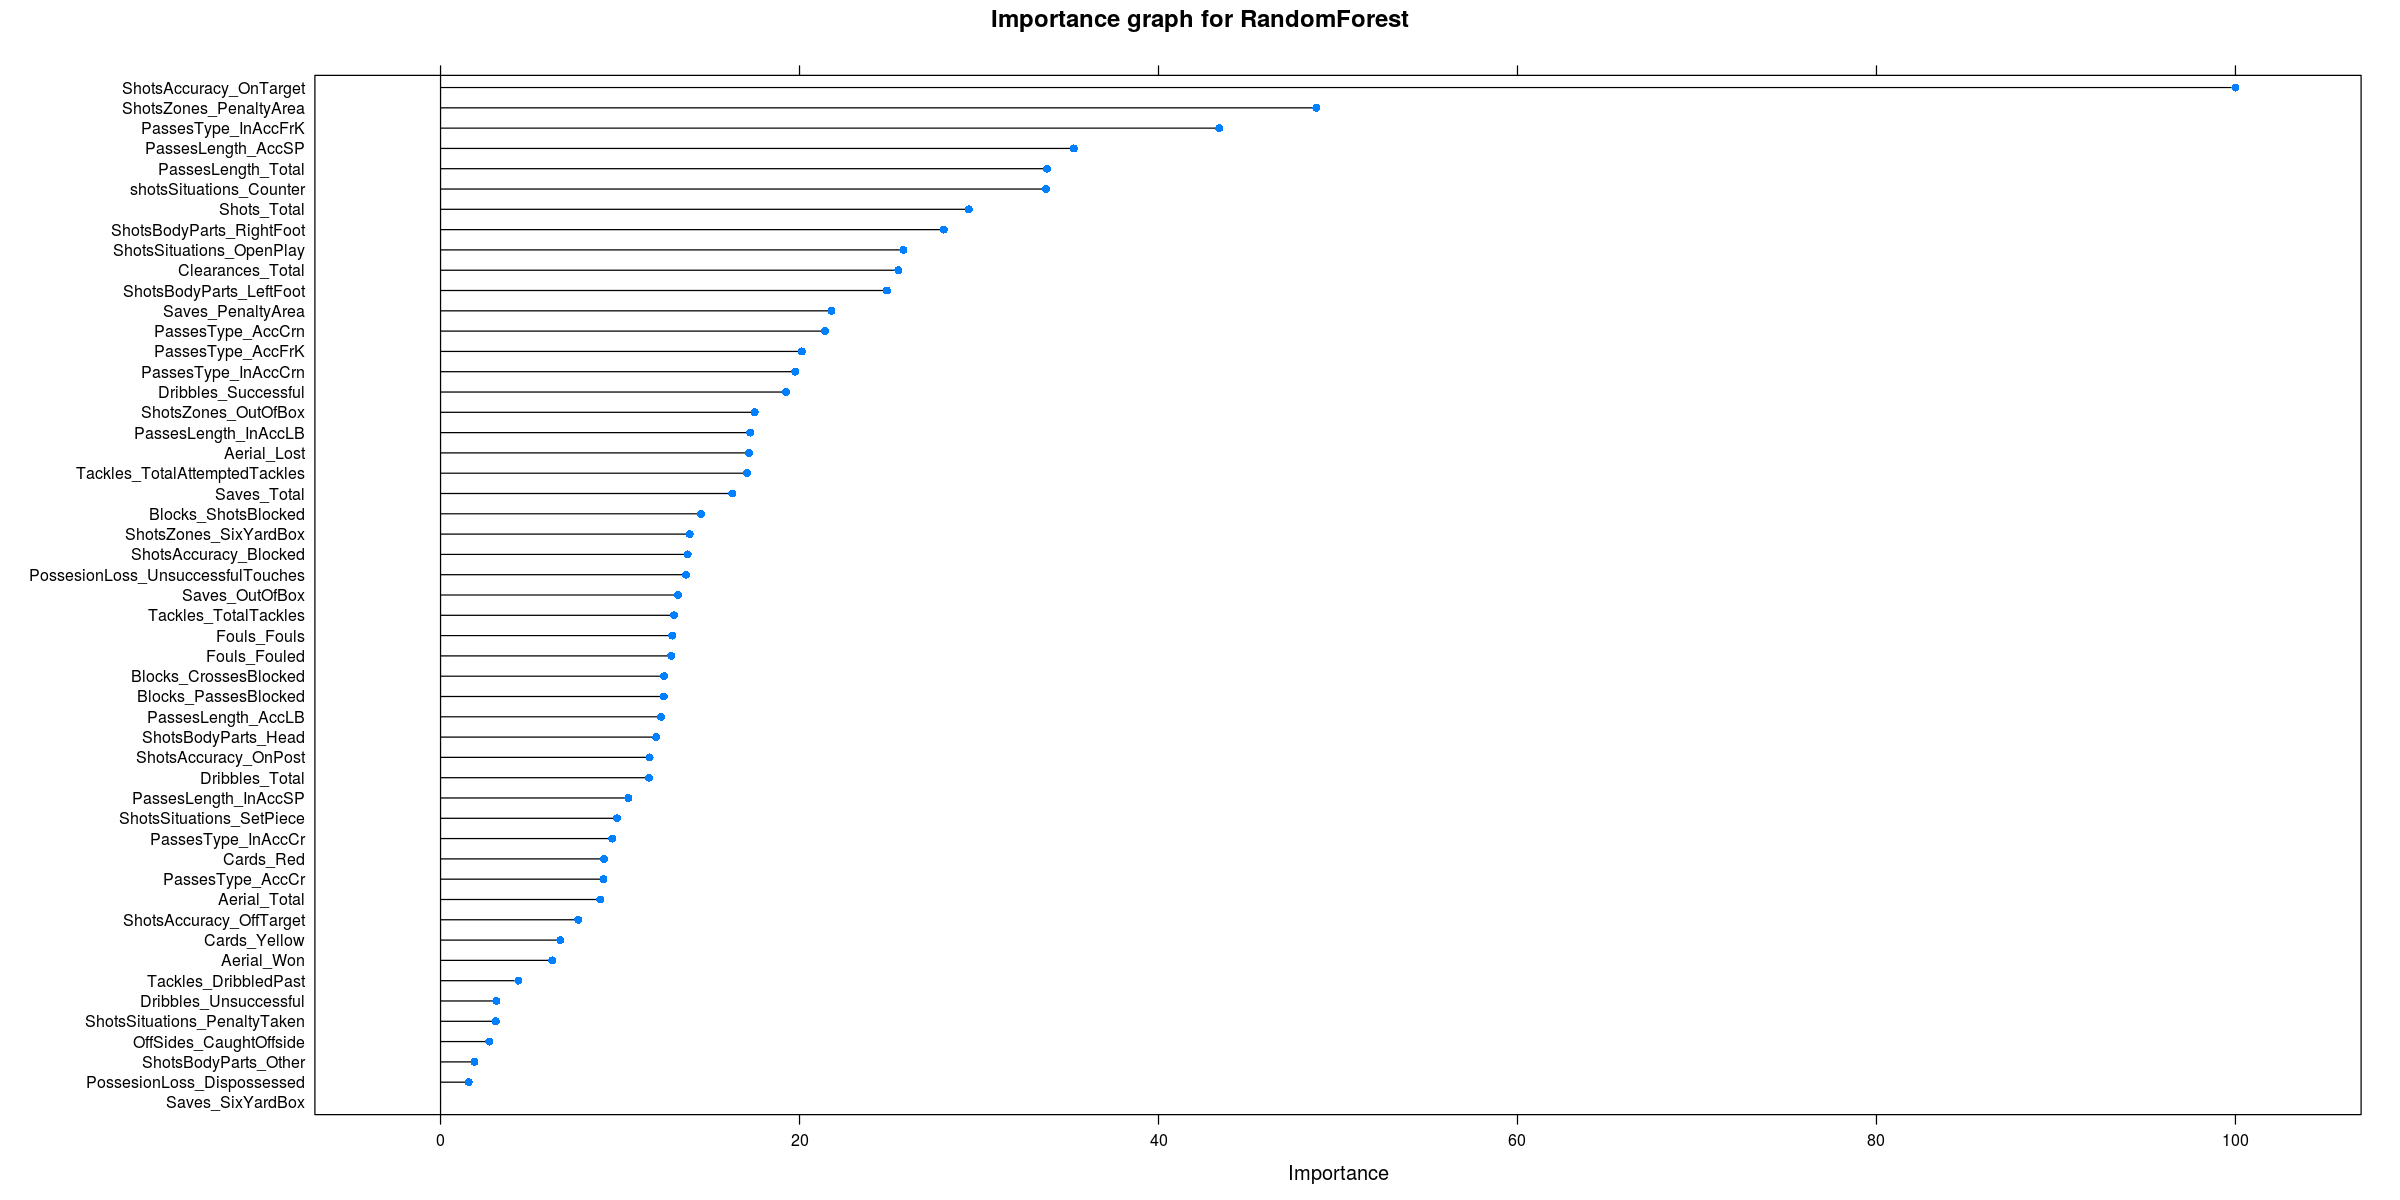

In [44]:
plot(varImp(rf.points.caret), main = "Importance graph for RandomForest")

In [61]:
nb_rf = 6

#### Erreur

In [147]:
min(rf.points.caret$results$RMSE)

[1] 9.950841

## SVM version caret pour extraire importance

In [41]:
svm.points = train(Points ~ ., data=data_but_tot_pts, method="svmLinear")

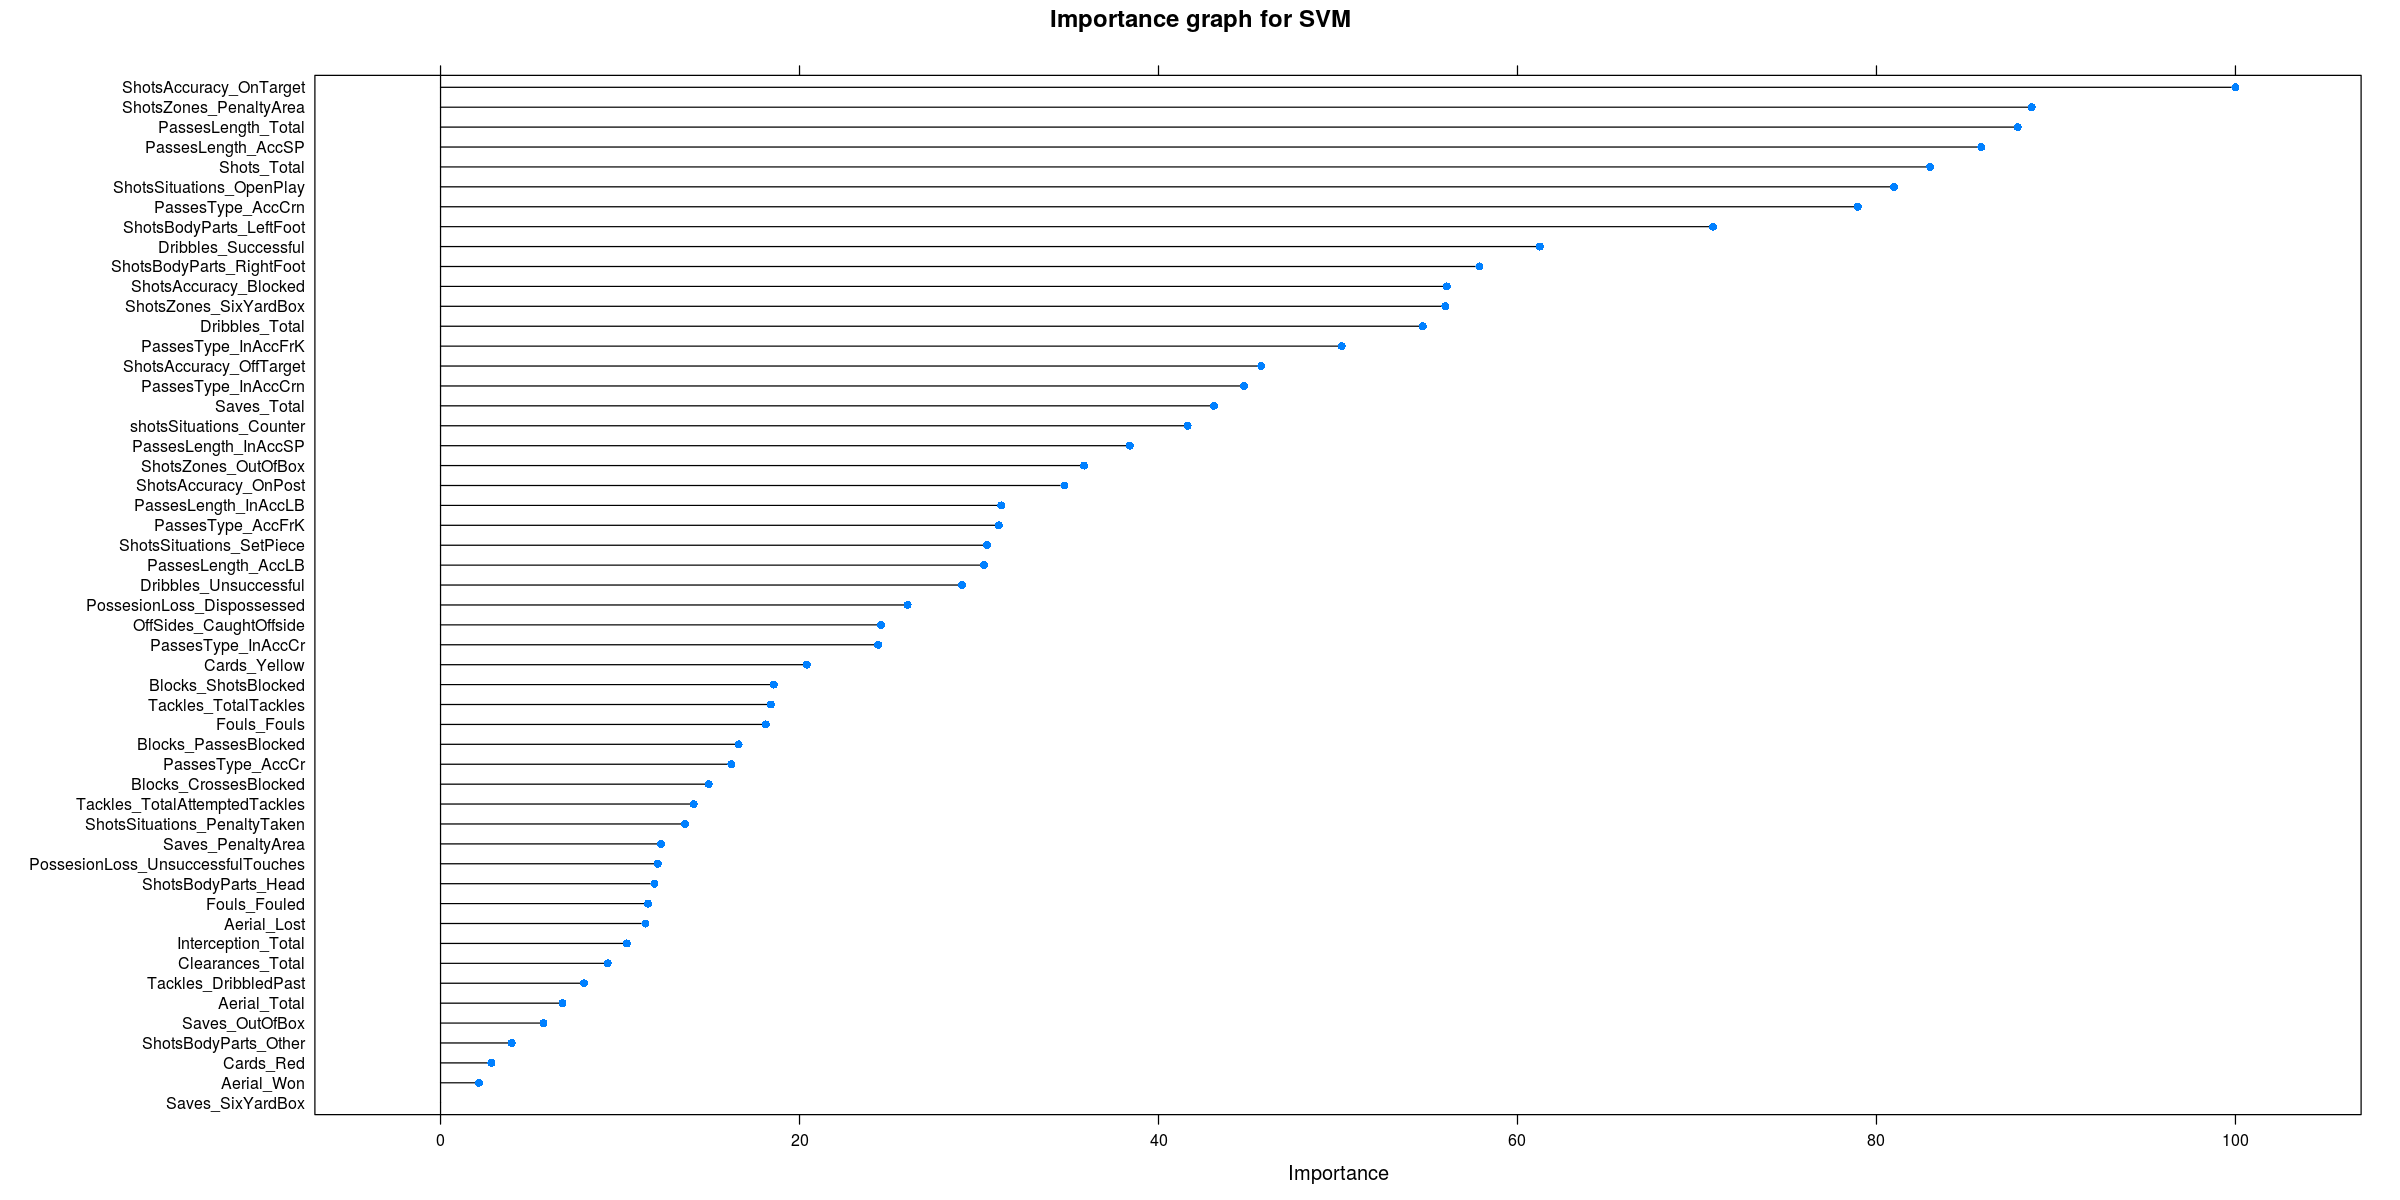

In [42]:
plot(varImp(svm.points), main = "Importance graph for SVM")

In [60]:
nb_svm = 7

#### Erreur

In [144]:
svm.points$results$RMSE

[1] 12.67779

### GBM light avec caret

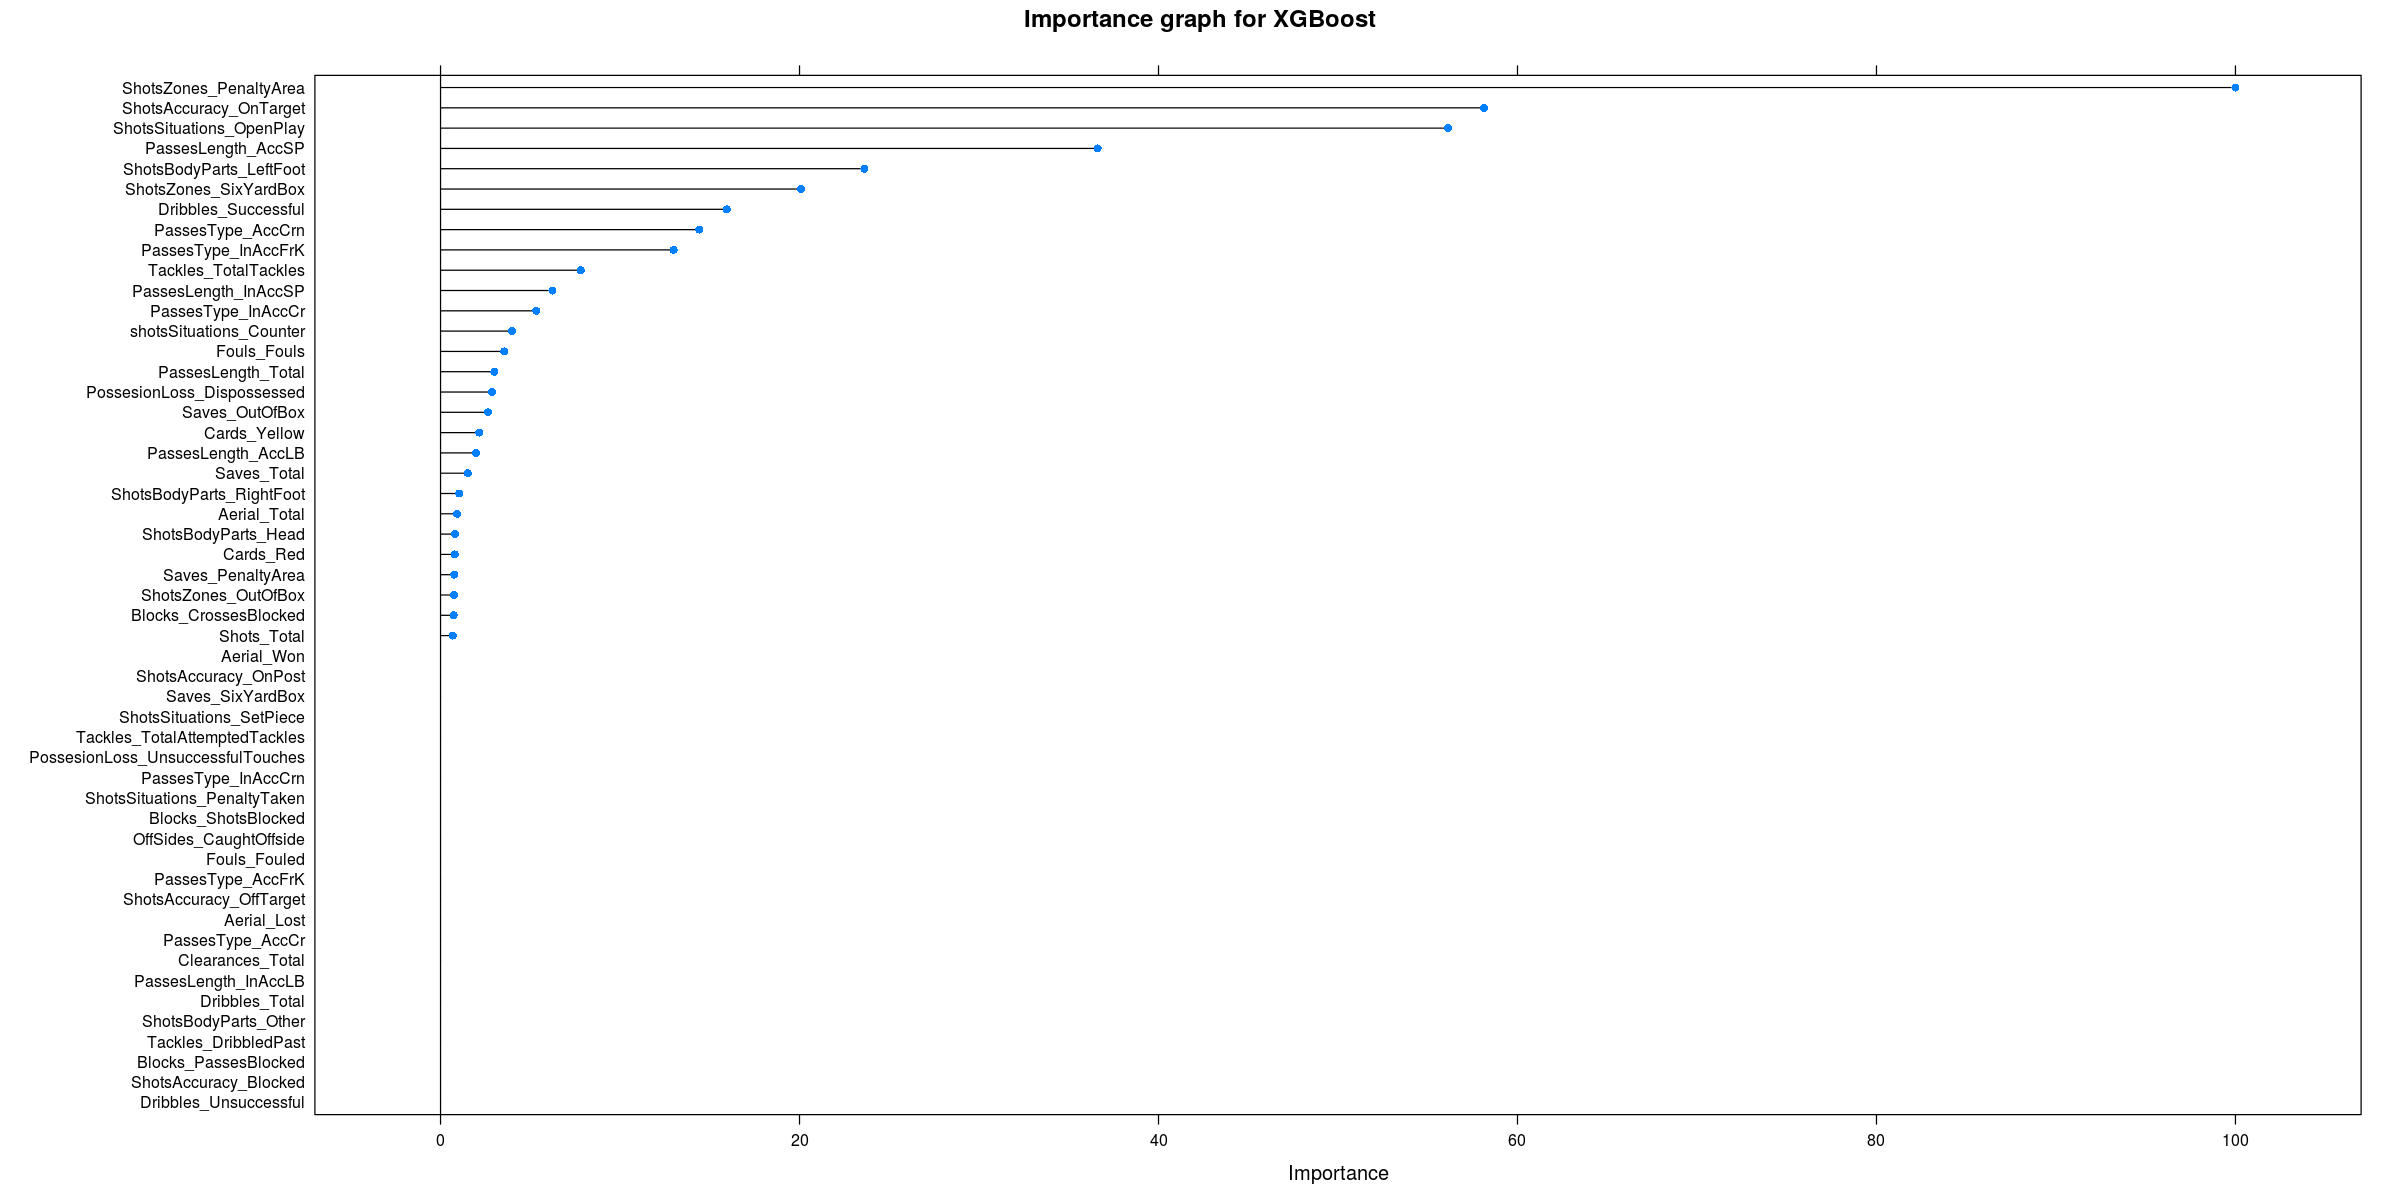

In [45]:
gbm.points = train(Points ~ ., data=data_but_tot_pts, method="xgbTree")
plot(varImp(gbm.points), main = "Importance graph for XGBoost")

In [59]:
nb_xgb = 6

#### Erreur

In [149]:
min(gbm.points$results$RMSE)

[1] 10.37818

### Comparaison des variables gardées

In [99]:
nb.variables = length(data_but_tot[1,])
df.variables = data.frame("RandomForest" = rep(0,nb.variables), 
                            "SVM" = rep(0,nb.variables),
                            "XGBoost" = rep(0,nb.variables))

rownames(df.variables) <- colnames(data_but_tot)

In [100]:

noms.rf = rownames(varImp(rf.points.caret)$importance)[order(-varImp(rf.points.caret)$importance)][1:nb_rf]
noms.svm = rownames(varImp(svm.points)$importance)[order(-varImp(svm.points)$importance)][1:nb_svm]
noms.xgb = rownames(varImp(gbm.points)$importance)[order(-varImp(gbm.points)$importance)][1:nb_xgb]
for (i in 1:nb.variables){
    df.variables[noms.rf, "RandomForest"] = 1
    df.variables[noms.xgb, "XGBoost"] = 1
    df.variables[noms.svm, "SVM"] = 1
    
}

In [103]:
df.variables0 = df.variables[rowSums(df.variables[,1:3]) > 0, ]
mat.variables.points = data.matrix(df.variables0[,1:3])

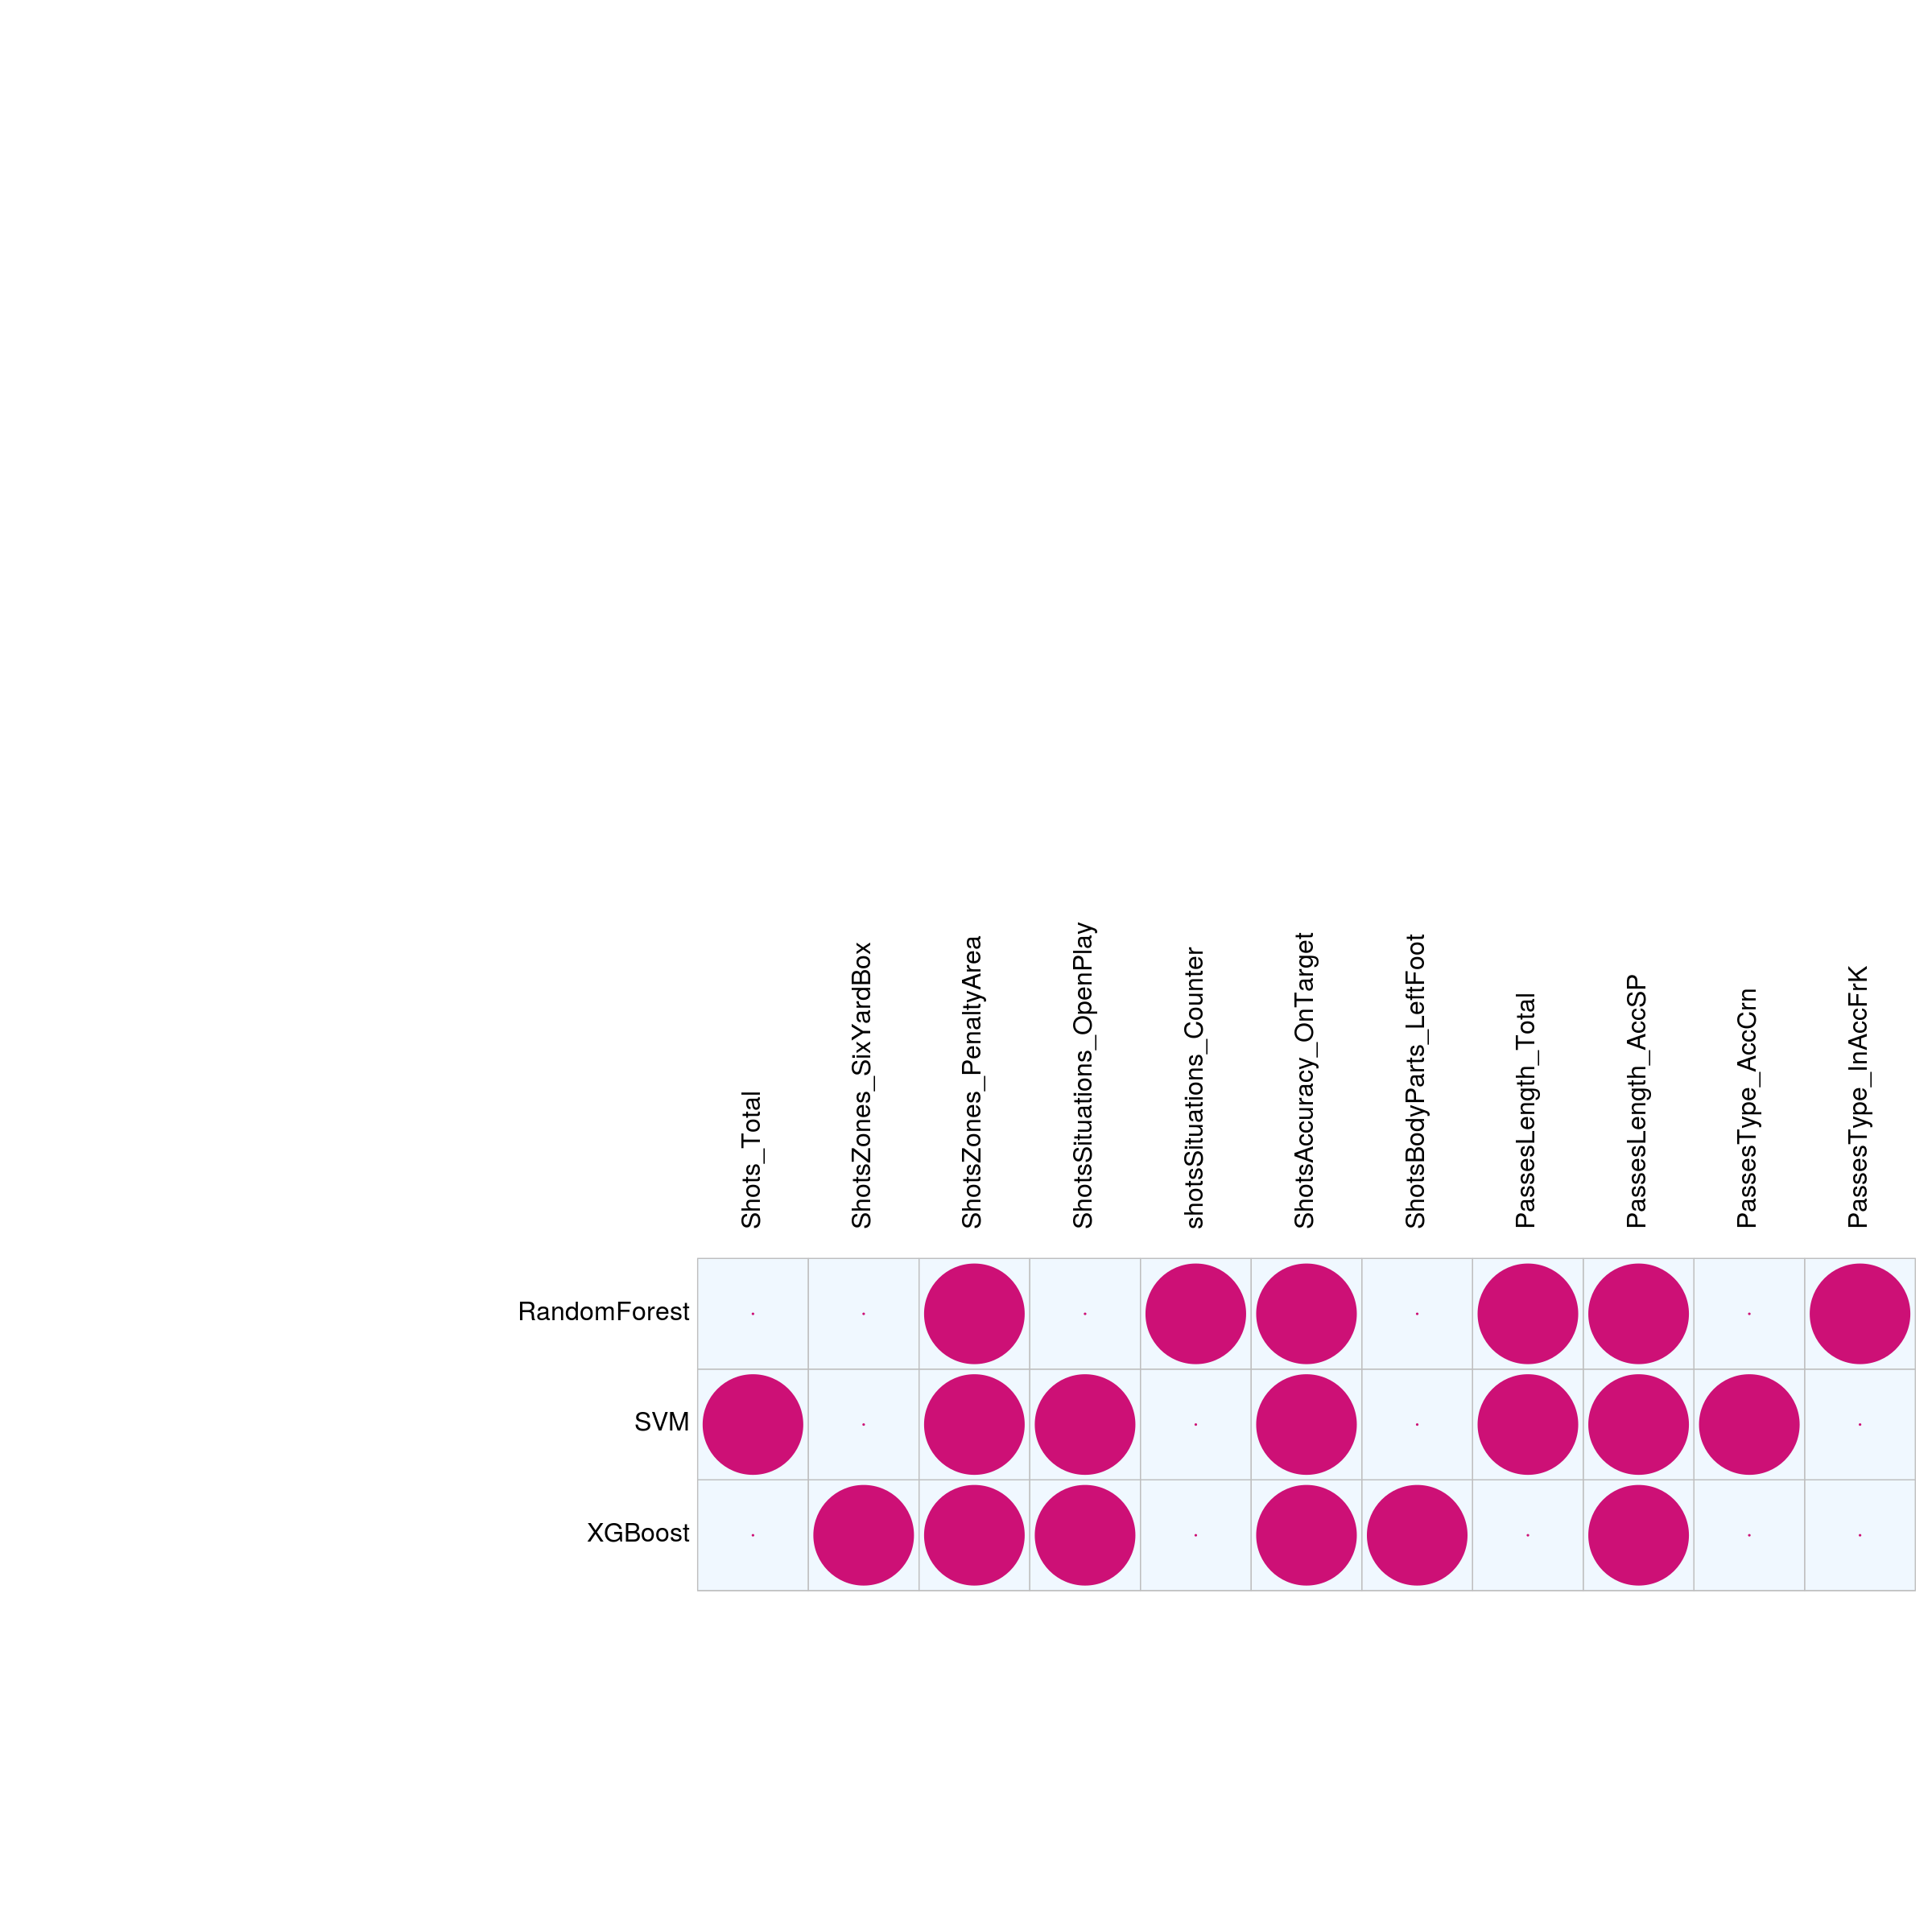

In [159]:
options(repr.plot.width=20, repr.plot.height=20)
corrplot(t(mat.variables.points), is.corr = FALSE, method = "circle", bg = "aliceblue", col = "deeppink3",tl.col = 1, cl.pos = "n", tl.cex = 1.6)#, main = "Nombre de points")#, col = c("blue", "red"))#, col = col1(100))
#title("                                                     Variable selection on the number of points, using machine learning methods", line = -38, cex.main = 2)